In [1]:
"""
% John Kath
% Math 178 - Nonlinear Data Analytics
% Summer 2019
% Final Project Code - 7/7/19

@author: John Kath
"""
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import os

from numpy import sin, cos, array, r_, vstack, abs, tile, pi
from numpy.linalg import norm

import skinematics as skin
from skinematics import imus, quat, vector, rotmat, view
from skinematics.sensors.manual import MyOwnSensor

In [2]:
# data pre processing
file_name_to_colume_names = {
    'Activity.csv': ['ID', 'SubjectID', 'Start_time', 'End_time', 'Relative_Start_time', 'Relative_End_time','Gesture_scenario', 'TaskID', 'ContentID'],
    'Accelerometer.csv': ['Systime', 'EventTime', 'ActivityID', 'X', 'Y', 'Z', 'Phone_orientation'],
    'Gyroscope.csv': ['Systime', 'EventTime', 'ActivityID', 'X', 'Y', 'Z', 'Phone_orientation'],
    'Magnetometer.csv': ['Systime', 'EventTime', 'ActivityID', 'X', 'Y', 'Z', 'Phone_orientation'],
}

In [3]:
def read_file(user_id: str, user_session_id: str, file_name: str, colume_names: List[str]) -> DataFrame:
    """
    Read one of the csv files for a user
    :param user_id: user id
    :param user_session_id: user session id
    :param file_name: csv file name (key of file_name_to_colume_names)
    :param colume_names: a list of column names of the csv file (value of file_name_to_colume_names)
    :return: content of the csv file as pandas DataFrame
    """
    # read data from csv
    filename = user_id + '_session_' + user_session_id + '_' + file_name
    csv_data = pd.read_csv(filename, names=colume_names)
    return pd.DataFrame(data=csv_data)

In [4]:
# pick the user as well as activities and extract features
userId = '984799';
session = '23';
# data_act = read_file(userId, session, 'Activity.csv', file_name_to_colume_names['Activity.csv'])
data_acc = read_file(userId, session, 'Accelerometer.csv', file_name_to_colume_names['Accelerometer.csv'])
data_gyr = read_file(userId, session, 'Gyroscope.csv', file_name_to_colume_names['Gyroscope.csv'])
data_mag = read_file(userId, session, 'Magnetometer.csv', file_name_to_colume_names['Magnetometer.csv'])
# print(data_acc.dtypes)
# print(data_gyr.dtypes)

In [5]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [6]:
def plot_orientation(x, y, title_name, y_label_name, file_name):
    # plot of feature
    plt.figure(figsize=(10, 5))
    plt.plot(x, y[:,0], alpha=0.5)
    plt.plot(x, y[:,1], alpha=0.5)
    plt.plot(x, y[:,2], alpha=0.5)
    plt.title(title_name)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label_name)
    plt.legend(['z-axis', 'y-axis', 'x-axis'],loc='upper right')
    save_fig(file_name)
    plt.show()

In [7]:
rate = 100.0
acc = np.column_stack((data_acc['X'], data_acc['Y'], data_acc['Z']))
omega = np.column_stack((data_gyr['X'], data_gyr['Y'], data_gyr['Z']))
mag = np.column_stack((data_mag['X'], data_mag['Y'], data_mag['Z']))
# adjust imu data length
length = min([len(acc), len(omega), len(mag)])
acc = acc[:length,:]
omega = omega[:length,:]
mag = mag[:length,:]

In [8]:
R_initialOrientation = np.eye(3)
initialPosition = np.zeros(3)

# q1, pos1 = analytical(R_initialOrientation, omega, initialPosition, acc, rate)
q_analytical, pos_analytical, vel_analytical = imus.analytical(R_initialOrientation, omega[:88000], initialPosition, acc[:88000], rate)
# express quat as Euler angles
e_analytical = quat.quat2seq(q_analytical, seq='Euler')

Saving figure 501973_12_analyticalfilter


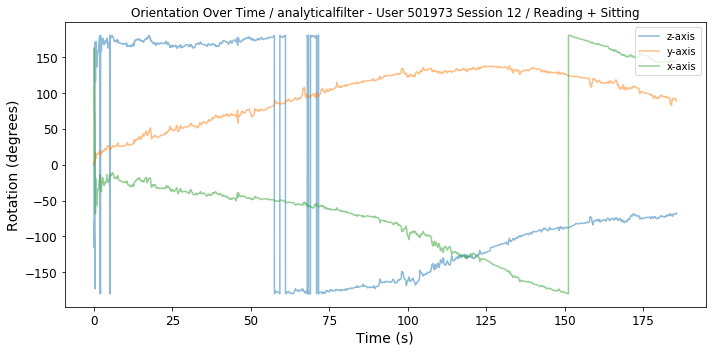

In [9]:
# time axis
time_i = [x / rate for x in list(range(0, len(e_analytical)))];
# plot_orientation(time_i, euler_angles, 'Orientation Over Time', 'Rotation (degrees)', file_name)
plot_orientation(time_i, e_analytical,
                 'Orientation Over Time / analyticalfilter - User ' + userId + ' Session ' + session + ' / Reading + Sitting',
                 'Rotation (degrees)',
                 userId + '_' + session + '_analyticalfilter')

In [10]:
# view.ts(e_analytical)

In [11]:
# out_file = 'q_analytical.mp4'
# view.orientation(q_analytical[:600], out_file, 'q_analytical Orientation', deltaT=1000./rate)

In [12]:
# imus.kalman(rate, acc, omega, mag)
q_Kalman = imus.kalman(rate, acc[:88000], omega[:88000], mag[:88000])
# r_Kalman = quat.convert(q_Kalman, to='rotmat')
# r_Kalman.reshape((-1,3))
# express quat as Euler angles
e_Kalman = quat.quat2seq(q_Kalman, seq='Euler')

Saving figure 501973_12_kalmanfilter


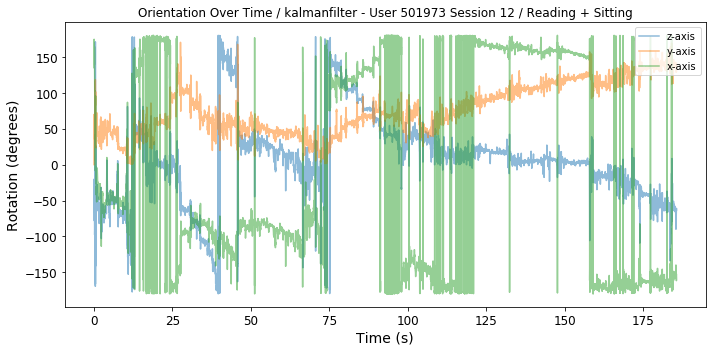

In [13]:
# time axis
time_i = [x / rate for x in list(range(0, len(e_Kalman)))];
# plot_orientation(time_i, euler_angles, 'Orientation Over Time', 'Rotation (degrees)', file_name)
plot_orientation(time_i, e_Kalman,
                 'Orientation Over Time / kalmanfilter - User ' + userId + ' Session ' + session + ' / Reading + Sitting',
                 'Rotation (degrees)',
                 userId + '_' + session + '_' + 'kalmanfilter')

In [14]:
# view.ts(e_Kalman)

In [15]:
# out_file = 'q_Kalman.mp4'
# view.orientation(q_Kalman[:600], out_file, 'q_Kalman Orientation', deltaT=1000./rate)

In [16]:
initialPosition = array([0,0,0])
R_initialOrientation = rotmat.R(0,90)

# get data
in_data = {'rate' : rate, 'acc' : acc[:88000], 'omega' : omega[:88000], 'mag' : mag[:88000]}

my_sensor = MyOwnSensor(in_file=None, in_data=in_data,
                        R_init=R_initialOrientation,
                        pos_init=initialPosition, 
                        q_type='madgwick')

# and then check, if the quat_vector = [0, sin(45), 0]
q_madgwick = my_sensor.quat
# express quat as rotation matrix
# r_madgwick = quat.convert(q_madgwick, to='rotmat')
# r_madgwick.reshape((-1,3))
# express quat as Euler angles
e_madgwick = quat.quat2seq(q_madgwick, seq='Euler')

result = quat.q_vector(q_madgwick[-1])
correct = array([ 0.,  np.sin(np.deg2rad(45)),  0.])
error = norm(result-correct)

Calculating the Quaternions [#########################] 18559/18559


Saving figure 501973_12_madgwickfilter


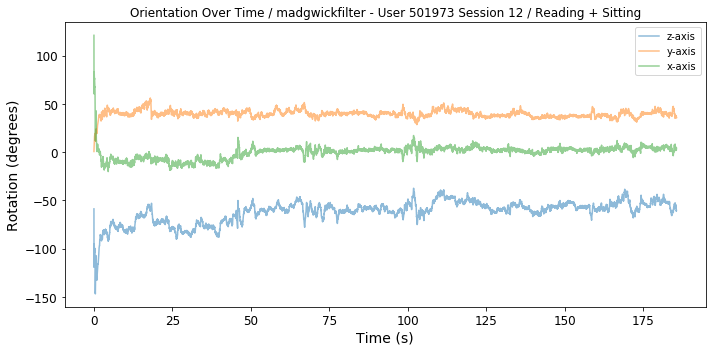

In [17]:
# time axis
time_i = [x / rate for x in list(range(0, len(e_madgwick)))];
# plot_orientation(time_i, euler_angles, 'Orientation Over Time', 'Rotation (degrees)', file_name)
plot_orientation(time_i, e_madgwick,
                 'Orientation Over Time / madgwickfilter - User ' + userId + ' Session ' + session + ' / Reading + Sitting',
                 'Rotation (degrees)',
                 userId + '_' + session + '_' + 'madgwickfilter')

In [18]:
# view.ts(e_madgwick)

In [19]:
# out_file = 'q_madgwick.mp4'
# view.orientation(q_madgwick[:600], out_file, 'q_madgwick Orientation', deltaT=1000./rate)

In [20]:
initialPosition = array([0,0,0])
R_initialOrientation = rotmat.R(0,90)

# get data
in_data = {'rate' : rate, 'acc' : acc[:88000], 'omega' : omega[:88000], 'mag' : mag[:88000]}

my_sensor = MyOwnSensor(in_file=None, in_data=in_data,
                        R_init=R_initialOrientation,
                        pos_init=initialPosition, 
                        q_type='mahony')

# and then check, if the quat_vector = [0, sin(45), 0]
q_mahony = my_sensor.quat
# express quat as rotation matrix
# r_mahony = quat.convert(q_mahony, to='rotmat')
# r_mahony.reshape((-1,3))
# express quat as Euler angles
e_mahony = quat.quat2seq(q_mahony, seq='Euler')

result = quat.q_vector(q_mahony[-1])
correct = array([ 0.,  np.sin(np.deg2rad(45)),  0.])
error = norm(result-correct)

Calculating the Quaternions [#########################] 18559/18559


Saving figure 501973_12_mahonyfilter


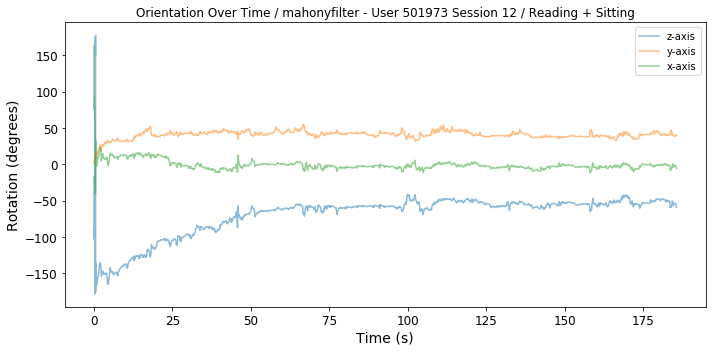

In [21]:
# time axis
time_i = [x / rate for x in list(range(0, len(e_mahony)))];
# plot_orientation(time_i, euler_angles, 'Orientation Over Time', 'Rotation (degrees)', file_name)
plot_orientation(time_i, e_mahony,
                 'Orientation Over Time / mahonyfilter - User ' + userId + ' Session ' + session + ' / Reading + Sitting',
                 'Rotation (degrees)',
                 userId + '_' + session + '_' +  'mahonyfilter')

In [22]:
# view.ts(e_mahony)

In [23]:
# out_file = 'q_mahony.mp4'
# view.orientation(q_mahony[:600], out_file, 'q_mahony Orientation', deltaT=1000./rate)